In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import mdtraj
import nglview as nv
import umap

In [2]:
path = os.path.abspath("")

In [3]:
traj = mdtraj.load("traj_openmm_gad_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")

In [4]:
traj.superpose(traj[0], )

<mdtraj.Trajectory with 10000 frames, 22 atoms, 3 residues, without unitcells at 0x135495a90>

In [5]:
nv.show_mdtraj(traj)

NGLWidget(max_frame=9999)

In [6]:
from scipy.spatial.distance import pdist

def calculate_pairwise_distances(points):
    """
    Calculate unique pairwise Euclidean distances for multiple sets of points.

    Parameters:
    - points: np.ndarray, shape (M, N, 3), array of M sets of N 3D points

    Returns:
    - distances: np.ndarray, shape (M, N*(N-1)//2), unique pairwise distances for each set
    """
    M, N, _ = points.shape
    pairwise_distances = np.zeros((M, N * (N - 1) // 2))
    
    for i in range(M):
        # Compute unique pairwise distances for the i-th set of points
        pairwise_distances[i] = pdist(points[i], metric='euclidean')
    
    return pairwise_distances

In [7]:
import numpy as np

def calculate_distance(p1, p2):
    """Calculate the distance between two points."""
    return np.linalg.norm(p2 - p1)

def calculate_angle(p1, p2, p3):
    """Calculate the angle (in degrees) formed by three points."""
    v1 = p1 - p2
    v2 = p3 - p2
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(cos_theta)

def calculate_dihedral(p1, p2, p3, p4):
    """Calculate the dihedral angle (in degrees) for four points."""
    b1 = p2 - p1
    b2 = p3 - p2
    b3 = p4 - p3

    # Normal vectors
    n1 = np.cross(b1, b2)
    n2 = np.cross(b2, b3)

    # Orthogonal vector to b2
    m1 = np.cross(n1, b2 / np.linalg.norm(b2))

    x = np.dot(n1, n2)
    y = np.dot(m1, n2)
    return np.arctan2(y, x)

def cartesian_to_z_matrix(coordinates):
    """Convert Cartesian coordinates to a Z-matrix."""
    z_matrix = []
    for i, coord in enumerate(coordinates):
        if i == 0:
            pass#z_matrix.append([i + 1, 0, 0, 0])
        elif i == 1:
            bond_length = calculate_distance(coordinates[i], coordinates[0])
            #z_matrix.append([i + 1, 1, bond_length, 0])
            z_matrix.append(bond_length)
        elif i == 2:
            bond_length = calculate_distance(coordinates[i], coordinates[1])
            bond_angle = np.cos(calculate_angle(coordinates[0], coordinates[1], coordinates[2]))
            #z_matrix.append([i + 1, 2, bond_length, bond_angle])
            z_matrix.append(bond_length)
            z_matrix.append(bond_angle)
        else:
            bond_length = calculate_distance(coordinates[i], coordinates[i - 1])
            bond_angle = np.cos(calculate_angle(coordinates[i - 2], coordinates[i - 1], coordinates[i]))
            dihedral = np.cos(calculate_dihedral(coordinates[i - 3], coordinates[i - 2], coordinates[i - 1], coordinates[i]))
            #z_matrix.append([i + 1, i, bond_length, bond_angle, dihedral])
            z_matrix.append(bond_length)
            z_matrix.append(bond_angle)
            z_matrix.append(dihedral)
    return np.asarray(z_matrix)

In [8]:
data_set = calculate_pairwise_distances(traj.xyz)

# data_set = []
# for frame in traj.xyz:
#     data_set.append(cartesian_to_z_matrix(frame))

# data_set = np.vstack(data_set)

In [10]:
phis = phis = mdtraj.compute_phi(traj)[1].ravel()

psis = mdtraj.compute_psi(traj)[1].ravel()
# Convert to degrees
phis = phis * 180 / np.pi
psis = psis * 180 / np.pi

# UMAP

In [31]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2)
embedded = reducer.fit_transform(data_set)

/Users/arminsh/miniconda3/envs/GAD/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


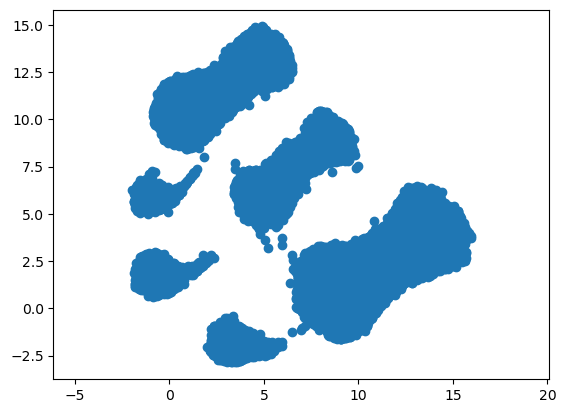

In [32]:
plt.scatter(
    embedded[:, 0],
    embedded[:, 1])
plt.gca().set_aspect('equal', 'datalim');

In [33]:
full_data = np.concatenate([phis.reshape(-1, 1), psis.reshape(-1, 1), embedded[:, 0].reshape(-1, 1), embedded[:, 1].reshape(-1, 1)], axis=1)

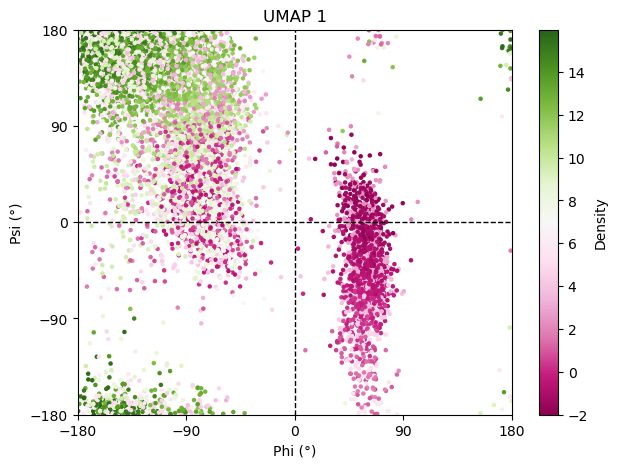

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 2], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("UMAP 1")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

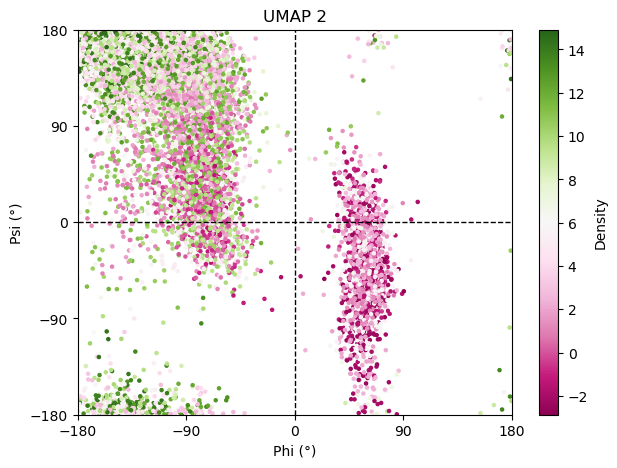

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 3], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("UMAP 2")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

# UMAP (cosine)

In [36]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2, metric="cosine")
embedded = reducer.fit_transform(data_set)

/Users/arminsh/miniconda3/envs/GAD/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


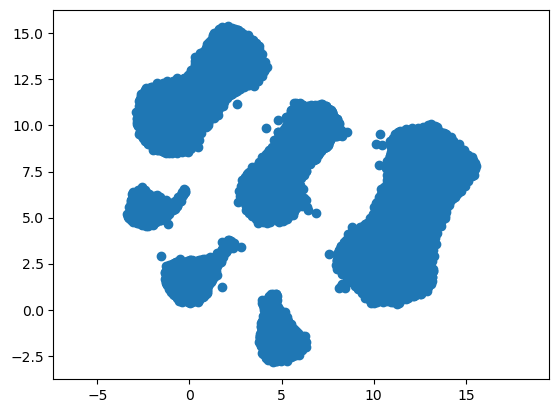

In [37]:
plt.scatter(
    embedded[:, 0],
    embedded[:, 1])
plt.gca().set_aspect('equal', 'datalim');

# kPCA

In [38]:
from sklearn.decomposition import KernelPCA

In [51]:
kernel_pca = KernelPCA(
    n_components=2, kernel="rbf", gamma=5, fit_inverse_transform=True, alpha=0.5
)

In [52]:
embedded = kernel_pca.fit(data_set).transform(data_set)

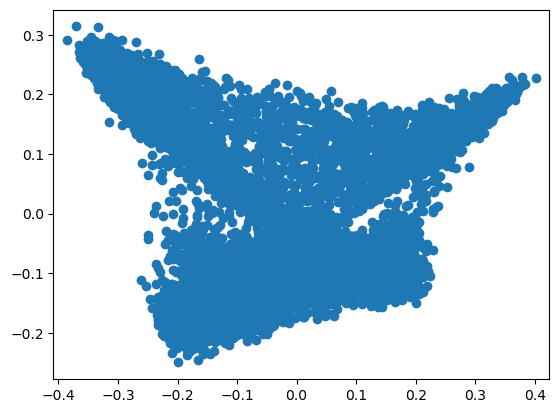

In [53]:
plt.scatter(
    embedded[:, 0],
    embedded[:, 1])
plt.gca().set_aspect('equal', 'datalim');

In [54]:
full_data = np.concatenate([phis.reshape(-1, 1), psis.reshape(-1, 1), embedded[:, 0].reshape(-1, 1), embedded[:, 1].reshape(-1, 1)], axis=1)

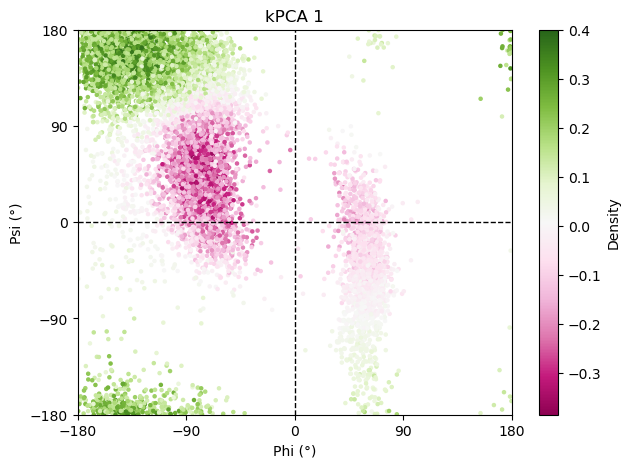

In [55]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 2], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("kPCA 1")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

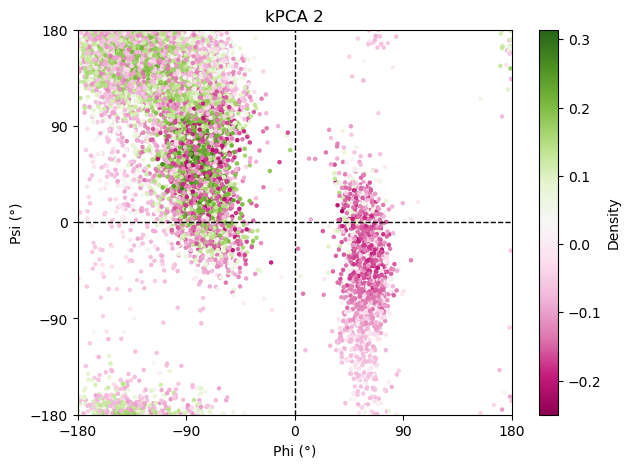

In [56]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 3], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("kPCA 2")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

# VAMP

In [57]:
from deeptime.decomposition import VAMP

In [58]:
vamp = VAMP(dim=2, lagtime=5)
vamp = vamp.fit(data_set).fetch_model()
embedded = vamp.transform(data_set)

In [59]:
full_data = np.concatenate([phis.reshape(-1, 1), psis.reshape(-1, 1), embedded[:, 0].reshape(-1, 1), embedded[:, 1].reshape(-1, 1)], axis=1)

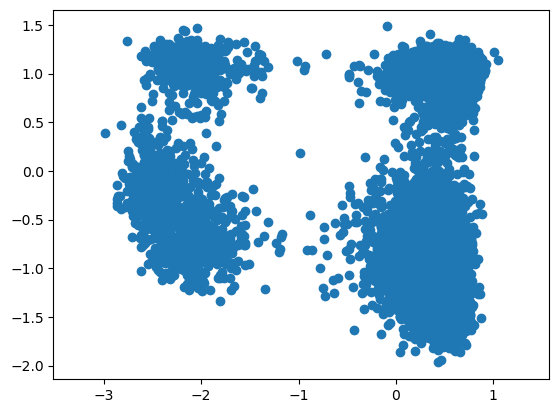

In [60]:
plt.scatter(
    embedded[:, 0],
    embedded[:, 1])
plt.gca().set_aspect('equal', 'datalim');

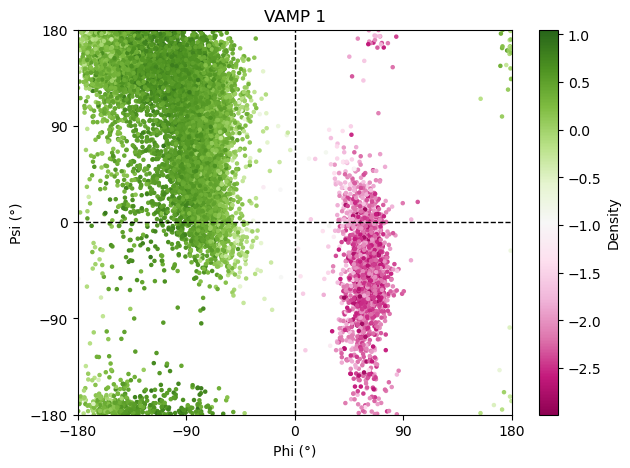

In [61]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 2], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("VAMP 1")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

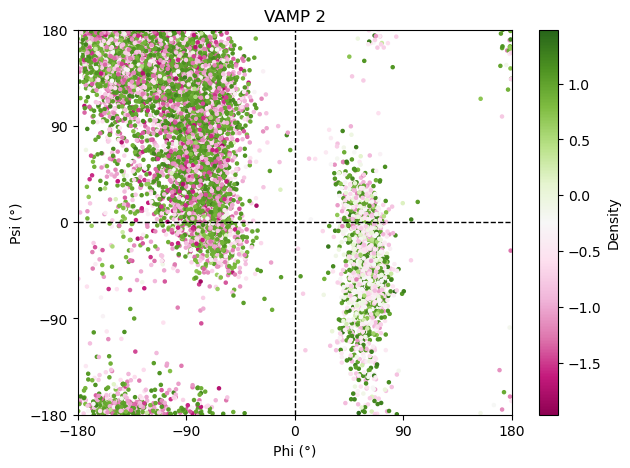

In [62]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 3], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("VAMP 2")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

# tSNE

In [63]:
from sklearn.manifold import TSNE

In [64]:
tSNE = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10)
embedded = tSNE.fit_transform(data_set)

In [65]:
full_data = np.concatenate([phis.reshape(-1, 1), psis.reshape(-1, 1), embedded[:, 0].reshape(-1, 1), embedded[:, 1].reshape(-1, 1)], axis=1)

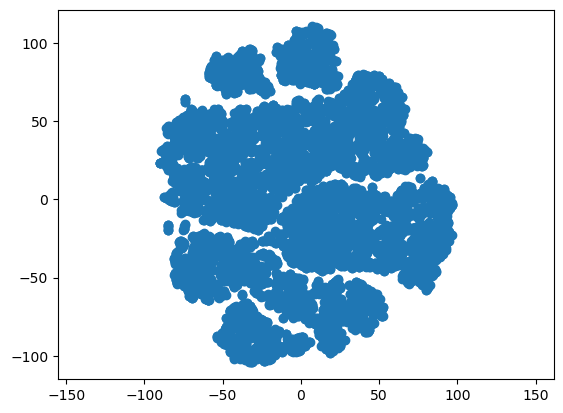

In [66]:
plt.scatter(
    embedded[:, 0],
    embedded[:, 1])
plt.gca().set_aspect('equal', 'datalim');

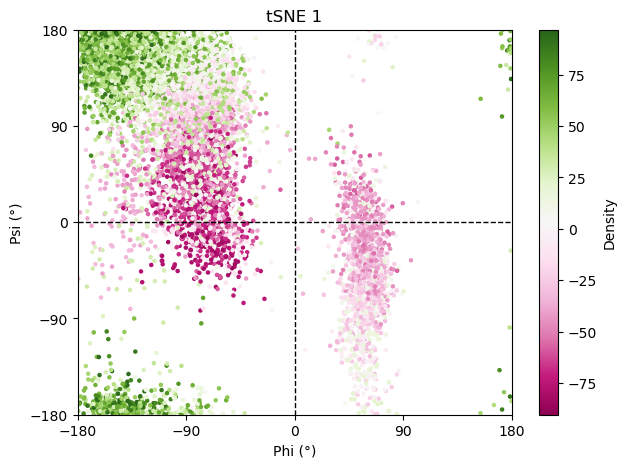

In [67]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 2], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("tSNE 1")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

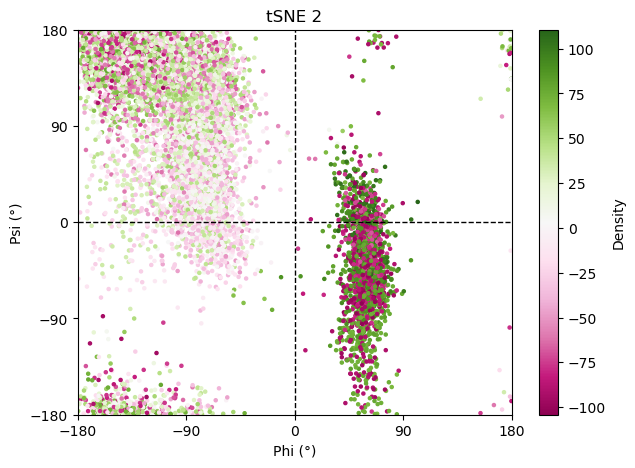

In [68]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 3], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("tSNE 2")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

# tSNE (cos)

In [69]:
tSNE = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50, metric="cosine")
embedded = tSNE.fit_transform(data_set)

In [70]:
full_data = np.concatenate([phis.reshape(-1, 1), psis.reshape(-1, 1), embedded[:, 0].reshape(-1, 1), embedded[:, 1].reshape(-1, 1)], axis=1)

In [71]:
full_data = np.concatenate([phis.reshape(-1, 1), psis.reshape(-1, 1), embedded[:, 0].reshape(-1, 1), embedded[:, 1].reshape(-1, 1)], axis=1)

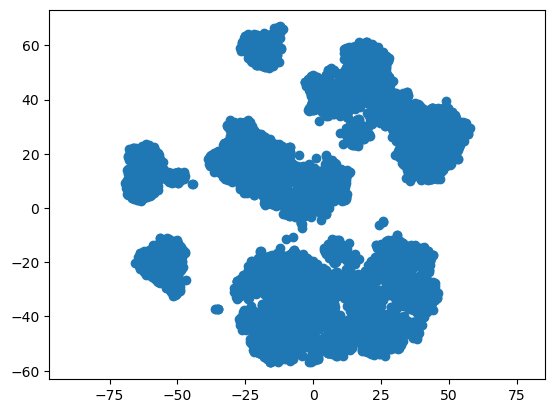

In [72]:
plt.scatter(
    embedded[:, 0],
    embedded[:, 1])
plt.gca().set_aspect('equal', 'datalim');

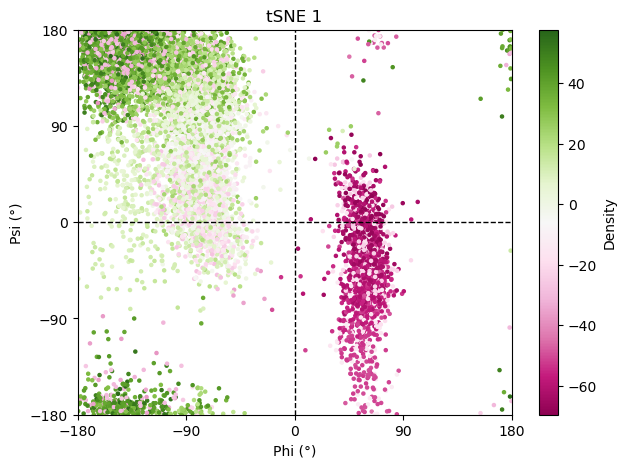

In [73]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 2], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("tSNE 1")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")

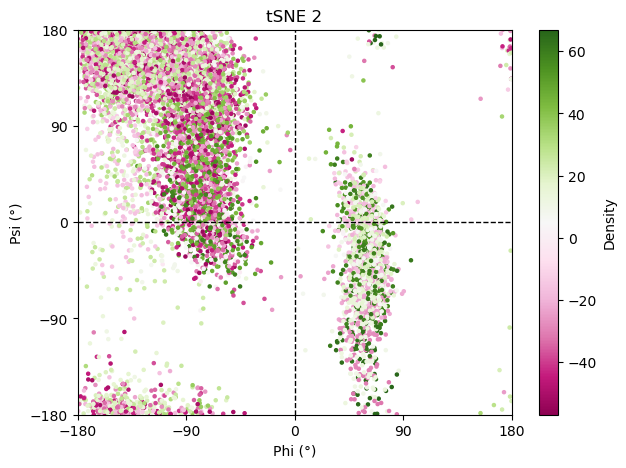

In [74]:
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(full_data[:, 0], full_data[:, 1], c=full_data[:, 3], cmap="PiYG", s=5)
ax.axvline(0, color="k", linestyle="--", lw=1)
ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xticks(np.linspace(-180, 180, 5))
ax.set_yticks(np.linspace(-180, 180, 5))
ax.set_xlabel("Phi (°)")
ax.set_ylabel("Psi (°)")
ax.set_title("tSNE 2")
# ax.set_title("Ramachandran Plot (Contour Density)")
fig.colorbar(sc, label="Density")